## Downloading Dataset and KerasCV

In [1]:
!curl -s -L "https://universe.roboflow.com/ds/1i3gXGrY97?key=SkyD74ZzLp" > roboflow.zip; unzip -o -qq roboflow.zip; rm roboflow.zip

In [2]:
!pip install --upgrade keras-cv tensorflow
!pip install --upgrade keras

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 613.1/613.1 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 589.8/589.8 MB 2.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 950.8/950.8 kB 51.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 80.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 72.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 87.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 54.3 MB/s eta 0:00:00
  Attempting uninstall: ml-dtypes
    Found existing installation: ml-dtypes 0.2.0
    Uninstalling ml-dtypes-0.2.0:
      Successfully uninstalled ml-dtypes-0.2.0
  Attempting uninstall: h5py
    Found existing installation: h5py 3.9.0
    Uninstalling h5py-3.9.0:
      Successfully uninstalled h5py-3.9.0
  Attempting uninstall: tensorboard
    Found existing installation: tensorboard 2.15.2
    Uninstalling tensorboard-2.15.2:
    

## Data Preprocessing

In [11]:
import keras_cv, keras
import tensorflow as tf
import json, os

splits = {
    'train': '/content/train',
    'test': '/content/test',
    'validation': '/content/valid'
}

output_spec = {
    'images': tf.TensorSpec(shape=(None, None, 3)),
    'bounding_boxes': {
        'boxes': tf.TensorSpec(shape=(None, 4)),
        'classes': tf.TensorSpec(shape=(None,))
      }
}

class_mapping = {
    0: "elbow positive",
    1: "fingers positive",
    2: "forearm fracture",
    3: "humerus fracture",
    4: "shoulder fracture",
    5: "wrist positive"
}

label_to_id = {v: k for k, v in class_mapping.items()}

def load_image(filepath):
  image_data = tf.io.read_file(filepath)
  return tf.cast(tf.io.decode_jpeg(image_data, channels=3), tf.float32)

def load(split):

  with open((splits[split]+'/_annotations.createml.json')) as f:
    annotations_file = json.load(f)

  def generator():
    for entry in annotations_file:
      annotations = entry['annotations']
      image_path = entry['image']

      box_labels = []
      class_labels = []

      for annotation in annotations:
        box = annotation['coordinates']
        box_label = tf.constant([box['x'], box['y'], box['width'], box['height']], tf.float32)
        class_label = annotation['label']

        box_labels.append(box_label)
        class_labels.append(label_to_id[class_label])

      if len(box_labels) == 0:
        continue

      bounding_boxes = {
            'boxes': tf.stack(box_labels),
            'classes': tf.stack(class_labels)
        }

      image = load_image((splits[split] + '/' + image_path))

      bounding_boxes = keras_cv.bounding_box.convert_format(bounding_boxes, source ='center_xywh', target='center_xywh')

      yield {
            'images': image,
            'bounding_boxes': bounding_boxes
        }

  return tf.data.Dataset.from_generator(generator, output_signature=output_spec, )

train_ds = load('train')
eval_ds = load('validation')

train_ds = train_ds.ragged_batch(16)
eval_ds = eval_ds.ragged_batch(16)

## Visualizing Dataset

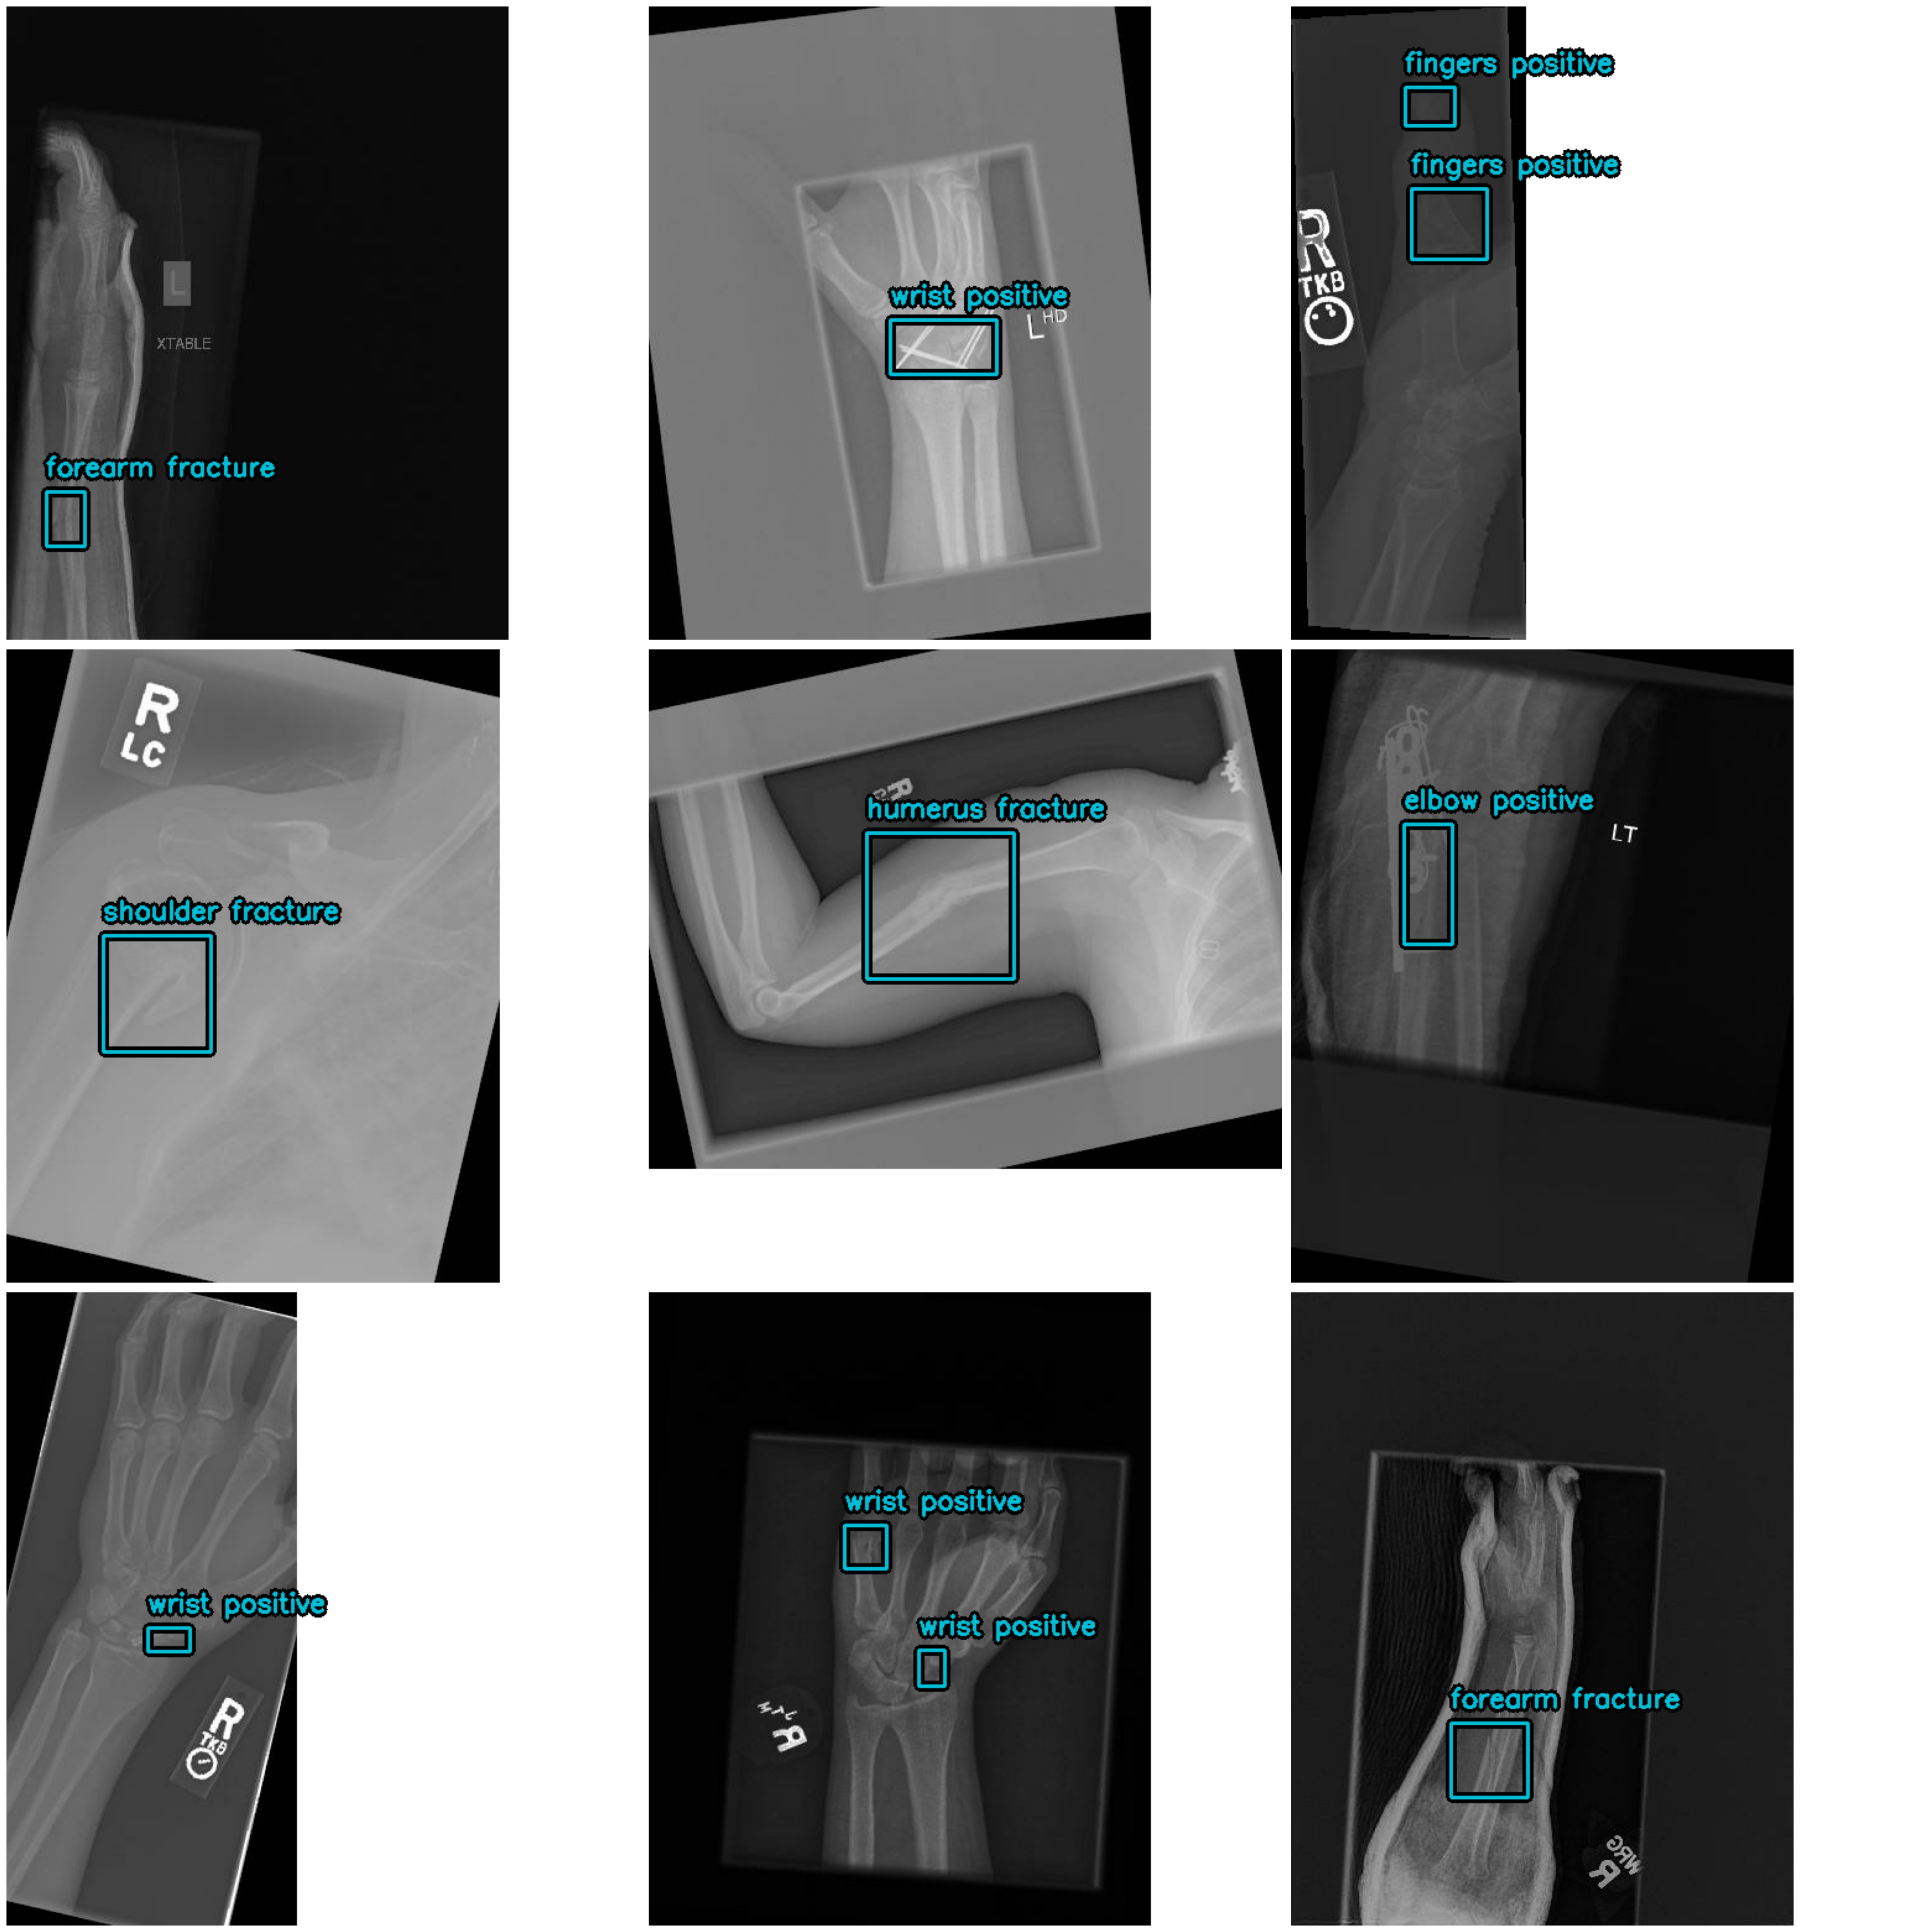

In [8]:
from keras_cv import visualization



def visualize_dataset(inputs, value_range, rows, cols, bounding_box_format):
    inputs = next(iter(inputs.take(1)))
    images, bounding_boxes = inputs["images"], inputs["bounding_boxes"]
    visualization.plot_bounding_box_gallery(
        images,
        value_range=value_range,
        rows=rows,
        cols=cols,
        y_true=bounding_boxes,
        scale=10,
        font_scale=0.7,
        bounding_box_format='center_xywh',
        class_mapping = class_mapping,
    )

visualize_dataset(
    train_ds,
    value_range=(0, 255),
    rows=3,
    cols=3,
    bounding_box_format='center_xywh'
)


## Augmentation

In [12]:
augmenter = keras.Sequential(
    layers=[
        keras_cv.layers.JitteredResize(
            target_size=(512, 512), scale_factor=(0.75, 1.3), bounding_box_format="center_xywh"
        ),
    ]
)

inference_resizing = keras_cv.layers.Resizing(
    512, 512, pad_to_aspect_ratio=True, bounding_box_format="center_xywh"
)

train_ds = train_ds.map(augmenter, num_parallel_calls=tf.data.AUTOTUNE)
eval_ds = eval_ds.map(inference_resizing, num_parallel_calls=tf.data.AUTOTUNE)

train_ds = train_ds.prefetch(tf.data.AUTOTUNE)
eval_ds = eval_ds.prefetch(tf.data.AUTOTUNE)

## Defining Model

In [13]:
from keras import optimizers

model = keras_cv.models.RetinaNet.from_preset(
    "resnet50_imagenet",
    num_classes=len(class_mapping),
    bounding_box_format="center_xywh",
)

optimizer = optimizers.SGD(
    decay=5e-4,
    momentum=0.9,
    global_clipnorm=10.
)

model.compile(
    optimizer=optimizer,
    classification_loss="focal",
    box_loss="smoothl1",
)

/usr/local/lib/python3.10/dist-packages/keras/src/optimizers/base_optimizer.py:34: UserWarning: Argument `decay` is no longer supported and will be ignored.
  warnings.warn(


In [ ]:
history = model.fit(
  train_ds.take(1),
  validation_data=eval_ds.take(1),
  epochs=20 # EPOCHS
)

Epoch 1/20
